Data Cleaning and Preprocessing

In [1]:


import pandas as pd

# Function to clean column names by stripping whitespace
def clean_column_names(df):
    df.columns = df.columns.str.strip()
    return df

# Load the datasets
fear_greed_df = pd.read_csv("/content/fear_greed_index.csv")
historical_df = pd.read_csv("/content/historical_data.csv")

# Clean column names
fear_greed_df = clean_column_names(fear_greed_df)
historical_df = clean_column_names(historical_df)

# Convert 'date' column to datetime in fear_greed_df
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

# Convert 'Timestamp IST' to datetime in historical_df and extract date
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
historical_df['trade_date'] = historical_df['Timestamp IST'].dt.date
historical_df['trade_date'] = pd.to_datetime(historical_df['trade_date'])

# Aggregate historical data to a daily level
daily_performance_df = historical_df.groupby('trade_date').agg(
    total_closed_pnl=('Closed PnL', 'sum'),
    total_size_usd=('Size USD', 'sum'),
    avg_execution_price=('Execution Price', 'mean')
).reset_index()

# Merge the two dataframes on the date column
fear_greed_df = fear_greed_df.rename(columns={'date': 'trade_date'})
merged_df = pd.merge(daily_performance_df, fear_greed_df, on='trade_date', how='inner')

# Display the information of the merged dataframe
print("Merged DataFrame Info:")
print(merged_df.info())
print("\nFirst 5 rows of Merged DataFrame:")
print(merged_df.head())

# Save the merged DataFrame to a CSV file for future use
merged_df.to_csv("merged_analysis_data.csv", index=False)


Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trade_date           479 non-null    datetime64[ns]
 1   total_closed_pnl     479 non-null    float64       
 2   total_size_usd       479 non-null    float64       
 3   avg_execution_price  479 non-null    float64       
 4   timestamp            479 non-null    int64         
 5   value                479 non-null    int64         
 6   classification       479 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 26.3+ KB
None

First 5 rows of Merged DataFrame:
  trade_date  total_closed_pnl  total_size_usd  avg_execution_price  \
0 2023-05-01          0.000000          477.00          1898.133333   
1 2023-12-05          0.000000        50005.83         11038.300000   
2 2023-12-14       -205.4

Exploratory Data Analysis and Visualization

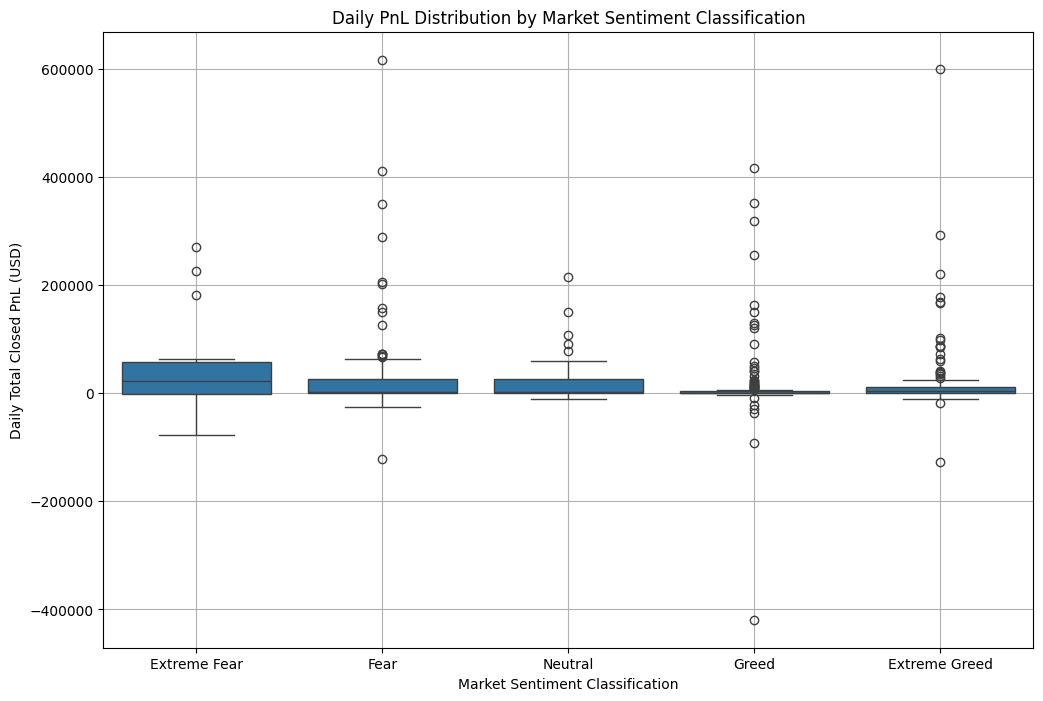

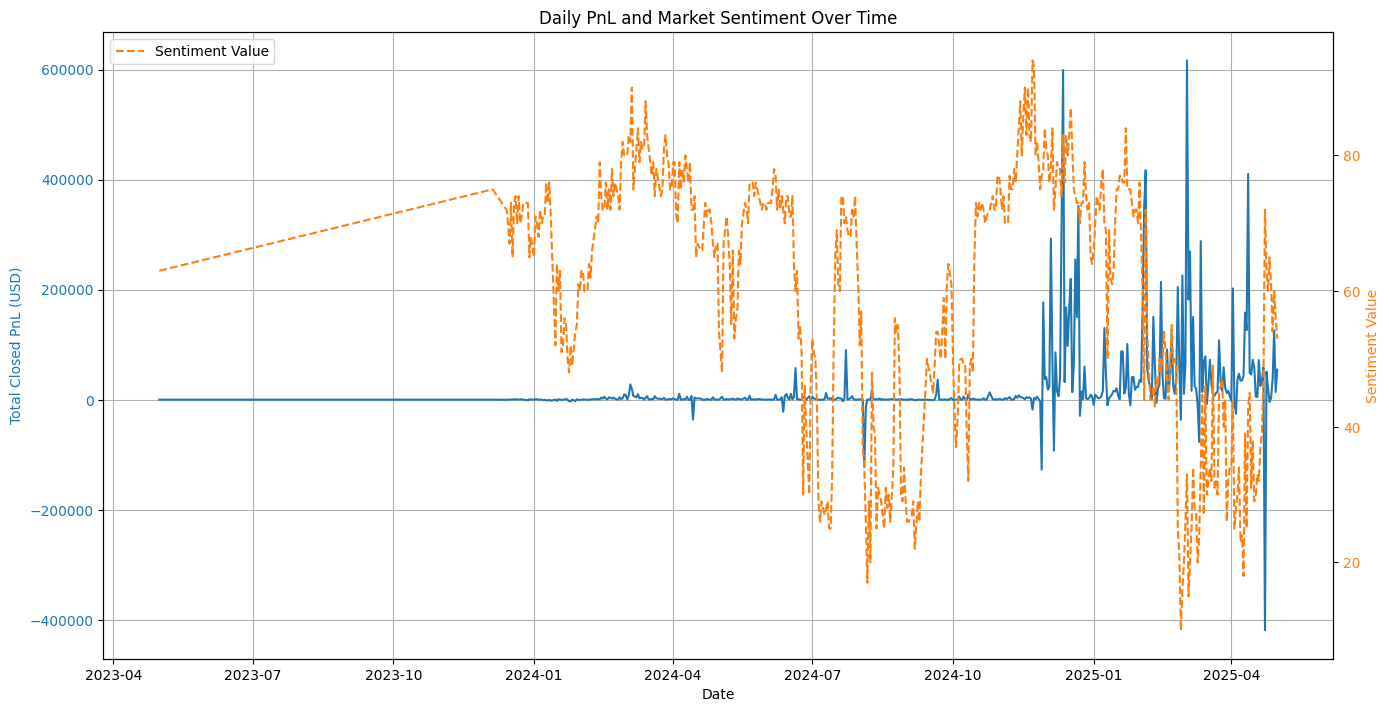

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
merged_df = pd.read_csv("/content/merged_analysis_data.csv")

# Ensure 'trade_date' is in datetime format
merged_df['trade_date'] = pd.to_datetime(merged_df['trade_date'])

# Create a box plot to compare the distribution of PnL across sentiment classifications
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification', y='total_closed_pnl', data=merged_df,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Daily PnL Distribution by Market Sentiment Classification')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Daily Total Closed PnL (USD)')
plt.grid(True)
plt.savefig('pnl_by_sentiment_boxplot.png')
plt.show()

# Create a time series plot of PnL and Sentiment
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot PnL on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Closed PnL (USD)', color=color)
ax1.plot(merged_df['trade_date'], merged_df['total_closed_pnl'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis for sentiment classification
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Sentiment Value', color=color)
ax2.plot(merged_df['trade_date'], merged_df['value'], color=color, linestyle='--', label='Sentiment Value')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')

# Title and layout
fig.tight_layout()
plt.title('Daily PnL and Market Sentiment Over Time')
plt.savefig('pnl_and_sentiment_time_series.png')
plt.show()

 Correlation Analysis Code and Results

In [3]:
import pandas as pd

# Load the merged dataset
merged_df = pd.read_csv("/content/merged_analysis_data.csv")

# Create a mapping for sentiment classification to a numerical scale
sentiment_mapping = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}
merged_df['sentiment_numeric'] = merged_df['classification'].map(sentiment_mapping)

# Calculate the correlation between numerical sentiment and performance metrics
correlation_pnl_sentiment = merged_df['total_closed_pnl'].corr(merged_df['sentiment_numeric'])
correlation_size_sentiment = merged_df['total_size_usd'].corr(merged_df['sentiment_numeric'])

print("\n--- Correlation Results ---")
print(f"Correlation between Daily PnL and Market Sentiment: {correlation_pnl_sentiment:.4f}")
print(f"Correlation between Daily Total Trade Size (USD) and Market Sentiment: {correlation_size_sentiment:.4f}")


--- Correlation Results ---
Correlation between Daily PnL and Market Sentiment: -0.0961
Correlation between Daily Total Trade Size (USD) and Market Sentiment: -0.2735


The correlation between Daily PnL and Market Sentiment is -0.0961, which is a very weak negative correlation. This suggests that there isn't a strong linear relationship between the two variables. As sentiment moves from "Extreme Fear" (1) to "Extreme Greed" (5), the daily PnL tends to slightly decrease, but the effect is negligible.

The correlation between Daily Total Trade Size (USD) and Market Sentiment is -0.2735, which is a weak negative correlation. This suggests that, on days with more bullish sentiment (Greed), the total trade size tends to be lower. Conversely, on days with higher fear, traders are executing larger trades.